# Cat breed CNN classifier
This is a Convolutional Neural Network (CNN) that classifies cats based on their images into 6 breeds:
1. American Short hair
2. Bengal
3. Maine Soon
4. Ragdoll
5. Scottish Fold
6. Sphinx
   
We will leverage Pytorch for this task.

## Preamble: The dataset
We will be using the following public Kaggle dataset: https://www.kaggle.com/datasets/solothok/cat-breed 
It contains training data which has 200 images for each class and test data that has 50 images for each class.

## Imports
<hr>

In [108]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

plt.rcParams.update({'axes.grid': False})

CNNs are comupationally demanding to run. Ideally, we want to utilize a GPU to improve our performance instead of a CPU. The following code snippet checks that our GPU and Pytorch setup is working.

In [109]:
torch.cuda.is_available()

True

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU (CUDA) if available, else use CPU
print(f"Using device: {device.type}")

Using device: cuda


## 1. CNN from scratch
First, let's try to make a CNN from scratch for this task, and see how well it performs (spoiler: it won't be anywhere near as good as pre-trained models). This will also helps us understand how CNNs work and how we can adapt them to different tasks.

### 1.1 Read the data
We simply need to set the paths to our training and test sets. Keep in mind that we are not actually reading the data yet, just learning where it is.

In [111]:
import torchvision

TRAIN_DIR = "/kaggle/input/cat-breed/cat-breed/TRAIN"
TEST_DIR = "/kaggle/input/cat-breed/cat-breed/TEST"

In [112]:
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")

Classes: ['americanshorthair', 'bengal', 'mainecoon', 'ragdoll', 'scottishfold', 'sphinx']
Class count: 200, 200
Samples: 1200
First sample: ('/kaggle/input/cat-breed/cat-breed/TRAIN/americanshorthair/12--Pahami-Karakter-Menarik-seputar-Kucing-American-Shorthai.jpg', 0)


### 1.2 Transform images
The images in our dataset have all kinds of different resolutions and aspect ratios, we must normalize them to a specific shape and size to be able to work with them. We will tranform them into 200x200 images.

In [113]:
IMAGE_SIZE = (200, 200) # This does not depend on the size of the raw images

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=data_transforms)

### 1.3 Create batches
Our dataset is too large to be loaded all at once, we must instead create loaders to feed the data into our model in batches.

In [ ]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,          
    batch_size=BATCH_SIZE,  
    shuffle=True,           
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,          
    batch_size=BATCH_SIZE,  
    shuffle=True,          
)

In [115]:
# (Optional) Checking our batches

imgs, targets = next(iter(train_loader))

print(f"  Number of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape}") 
print(f"  Target batch size: {targets.shape}")

  Number of batches: 19
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([64, 3, 200, 200])
  Target batch size: torch.Size([64])


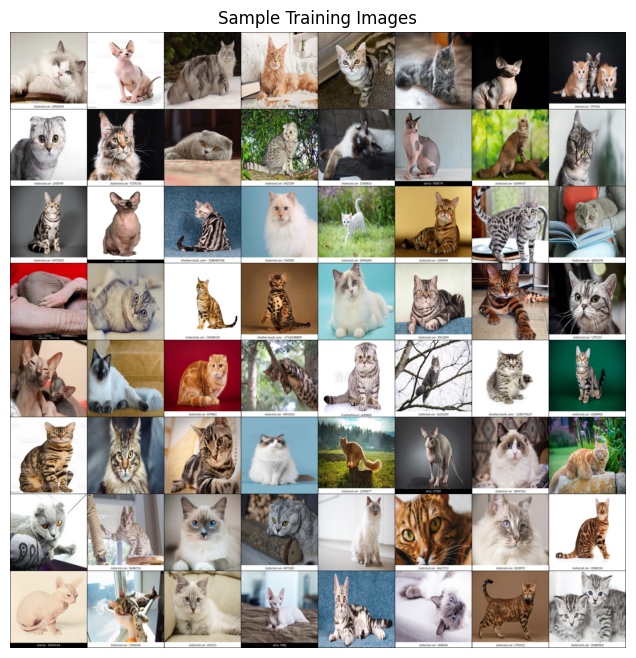

In [116]:
# A sample of our training data

sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

### 1.4 Create the CNN
Now, the fun part. We design a CNN using various functions from the Pytorch package. There is no right or wrong here, we simply experiment with different configuration until we reach a suitabel model.

In [117]:
import torch
import torch.nn as nn

class cat_CNN(nn.Module):
    def __init__(self):
        super(cat_CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout(0.2),

            nn.Flatten(),
            
            nn.Linear(256 * 12 * 12, 512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.ReLU(),

            nn.Linear(128, 6)
        )
        
    def forward(self, x):
        return self.model(x)
    

### 1.5 Train the model
It is time to train the model. In the function below, not only do we train the model, we also evaluate it after every epoch. This is useful for continuously observing the performance of our model, and can help us decide if we need to change the number of epochs, or adjust certain aspects of our model that may be causing overfitting, etc.  
Note: Training CNNs is computationally demanding. I am using Kaggle's GPU T4 x 2 accelerator to improve performance.

In [118]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
        train_loss.append(train_batch_loss / len(trainloader))
        
        # Validation
        model.eval()
        
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood
            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        

        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results    

In [130]:
# Training the model and observing its results

cat_model = cat_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cat_model.parameters(), lr=1e-3)

torch.manual_seed(792)

results = trainer(cat_model, criterion, optimizer, train_loader, test_loader, epochs=20)

Epoch 1: Train Loss: 5.406. Valid Loss: 3.333. Valid Accuracy: 0.15.
Epoch 2: Train Loss: 1.772. Valid Loss: 2.268. Valid Accuracy: 0.21.
Epoch 3: Train Loss: 1.360. Valid Loss: 1.645. Valid Accuracy: 0.31.
Epoch 4: Train Loss: 1.200. Valid Loss: 1.657. Valid Accuracy: 0.35.
Epoch 5: Train Loss: 1.119. Valid Loss: 1.452. Valid Accuracy: 0.40.
Epoch 6: Train Loss: 1.021. Valid Loss: 1.296. Valid Accuracy: 0.48.
Epoch 7: Train Loss: 1.023. Valid Loss: 1.439. Valid Accuracy: 0.40.
Epoch 8: Train Loss: 0.943. Valid Loss: 1.366. Valid Accuracy: 0.46.
Epoch 9: Train Loss: 0.811. Valid Loss: 1.414. Valid Accuracy: 0.50.
Epoch 10: Train Loss: 0.799. Valid Loss: 1.294. Valid Accuracy: 0.52.
Epoch 11: Train Loss: 0.686. Valid Loss: 1.226. Valid Accuracy: 0.53.
Epoch 12: Train Loss: 0.671. Valid Loss: 1.218. Valid Accuracy: 0.54.
Epoch 13: Train Loss: 0.665. Valid Loss: 1.236. Valid Accuracy: 0.52.
Epoch 14: Train Loss: 0.627. Valid Loss: 1.304. Valid Accuracy: 0.48.
Epoch 15: Train Loss: 0.511. 

We can see that our humble from-scratch model is able to correctly classify cat breeds approximately half the time. We can do a lot better by leveraging pre-trained models as we will explore in the next section.

## 2. Pre-trained models
We will explore how we can leverage pre-trained models to improve our model's performance. We will use DenseNet to extract features from our images, then feed it to our model to finally classify them.

### 2.1 Pre-trained model as-is
The simplest way to use a pre-trained model is to use it as-is, let's try that and see how it performs then decide whether or not we want to fine-tune it for our use case.

In [122]:
densenet = models.densenet121(pretrained=True)

for param in densenet.parameters():  # Freeze parameters so we don't update them (Keep model as-is)
    param.requires_grad = False

densenet.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [123]:
# Our classification layer
custom_classification_layer = nn.Sequential(
    nn.Linear(1024, 50),
    nn.ReLU(),
    nn.Linear(50, 6)
)

densenet.classifier = custom_classification_layer

densenet.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=6, bias=True)
)

Note: The DenseNet model is much larger and more complex than our scratch-made model. It is very computationally demanding.

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-3)


Using device: cuda


In [125]:
results = trainer(densenet, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1: Train Loss: 1.362. Valid Loss: 0.909. Valid Accuracy: 0.82.
Epoch 2: Train Loss: 0.677. Valid Loss: 0.536. Valid Accuracy: 0.89.
Epoch 3: Train Loss: 0.396. Valid Loss: 0.410. Valid Accuracy: 0.89.
Epoch 4: Train Loss: 0.303. Valid Loss: 0.329. Valid Accuracy: 0.90.
Epoch 5: Train Loss: 0.231. Valid Loss: 0.279. Valid Accuracy: 0.93.
Epoch 6: Train Loss: 0.200. Valid Loss: 0.255. Valid Accuracy: 0.91.
Epoch 7: Train Loss: 0.173. Valid Loss: 0.265. Valid Accuracy: 0.92.
Epoch 8: Train Loss: 0.177. Valid Loss: 0.272. Valid Accuracy: 0.91.
Epoch 9: Train Loss: 0.143. Valid Loss: 0.249. Valid Accuracy: 0.93.
Epoch 10: Train Loss: 0.128. Valid Loss: 0.212. Valid Accuracy: 0.92.


After leveraging the pre-trained model, our performance has become very impressive. Our model can now correctly classify cat breeds based on their images 92% of the time.

### 2.2: Fine-tuned pre-trained model

The DenseNet model is incredible, but it is forced to make certain compromises to generalize for different tasks. Let's try to fine-tune it so that it performs better for our specific cat breed classification task.  
There are plenty of ways to fine-tune a pre-trained model. In our case, we will explore 2 fine-tuning methods:  
1. Fully unfrozen pre-trained model.
2. Partially unfrozen pre-trained model.

#### 2.2.1 Fully unfrozen pre-trained model
This fine-tuning method throws away all of the learned parameters from the pre-trained model, and generates new ones by training it on our dataset. Essentially, it uses the architecture of the pre-trained model but throws away all of its previous training.

In [126]:
densenet_ft_full = models.densenet121(pretrained=True)
for param in densenet_ft_full.parameters():
    # Freeze parameters so we don't update them
    param.requires_grad = False

densenet_ft_full.classifier = custom_classification_layer # replace classification layer with ours

In [127]:
densenet_ft_full.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_ft_full.parameters(), lr=1e-3)
results = trainer(densenet_ft_full, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1: Train Loss: 0.144. Valid Loss: 0.250. Valid Accuracy: 0.90.
Epoch 2: Train Loss: 0.125. Valid Loss: 0.200. Valid Accuracy: 0.92.
Epoch 3: Train Loss: 0.091. Valid Loss: 0.193. Valid Accuracy: 0.94.
Epoch 4: Train Loss: 0.086. Valid Loss: 0.202. Valid Accuracy: 0.92.
Epoch 5: Train Loss: 0.084. Valid Loss: 0.192. Valid Accuracy: 0.92.
Epoch 6: Train Loss: 0.064. Valid Loss: 0.197. Valid Accuracy: 0.93.
Epoch 7: Train Loss: 0.065. Valid Loss: 0.189. Valid Accuracy: 0.93.
Epoch 8: Train Loss: 0.059. Valid Loss: 0.186. Valid Accuracy: 0.93.
Epoch 9: Train Loss: 0.065. Valid Loss: 0.214. Valid Accuracy: 0.92.
Epoch 10: Train Loss: 0.052. Valid Loss: 0.200. Valid Accuracy: 0.92.


We can see that the fully unfrozen pre-trained model performs very similarly to the as-is pre-trained model. This is mostly coincidental. Let's see if we can do better.

#### 2.2.1 Partially unfrozen pre-trained model
This fine-tuning method throws keeps almost everything from the pre-trained model, but fine-tunes a few of its layers (usually the last) to work better for our use case. These models should take less time to train as we're only training a few layers rather than training all of them.

In [128]:
densenet_ft_partial = models.densenet121(pretrained=True)
for layer in densenet_ft_partial.features[:-1]: # Freezing all but last layer
    for param in layer.parameters():
        param.requires_grad = False

densenet_ft_partial.classifier = custom_classification_layer

In [129]:
# Train the model
densenet_ft_partial.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_ft_partial.parameters(), lr=1e-3)
results = trainer(densenet_ft_partial, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1: Train Loss: 0.062. Valid Loss: 0.241. Valid Accuracy: 0.91.
Epoch 2: Train Loss: 0.058. Valid Loss: 0.236. Valid Accuracy: 0.93.
Epoch 3: Train Loss: 0.045. Valid Loss: 0.221. Valid Accuracy: 0.93.
Epoch 4: Train Loss: 0.041. Valid Loss: 0.215. Valid Accuracy: 0.92.
Epoch 5: Train Loss: 0.046. Valid Loss: 0.192. Valid Accuracy: 0.93.
Epoch 6: Train Loss: 0.029. Valid Loss: 0.186. Valid Accuracy: 0.92.
Epoch 7: Train Loss: 0.043. Valid Loss: 0.215. Valid Accuracy: 0.92.
Epoch 8: Train Loss: 0.032. Valid Loss: 0.190. Valid Accuracy: 0.93.
Epoch 9: Train Loss: 0.023. Valid Loss: 0.191. Valid Accuracy: 0.92.
Epoch 10: Train Loss: 0.022. Valid Loss: 0.199. Valid Accuracy: 0.93.


### Recap:  

1. From-scratch model performance: ~0.54 validation accuracy.
2. Densenet as-is model performance: ~0.92 validation accuracy.
3. Densenet fully unfrozen model performance: ~0.92 validation accuracy.
4. Densenet partially frozen model performance: ~0.93 validation accuracy.

Although additional fine-tuning is possible, we will likely get diminishing returns.

It is very interesting that the partially frozen model performed better than the fully unfrozen model. This suggests that the default weights of the densenet model are better than the weights we are creating as a result of training on our dataset. This makes sense because those default weights were likely created through much more training on much larger datasets. It is impressive that those default weights perform so well on our specific case even though they weren't created with classifying cat breeds in mind (it may have been part of its training, but definitely not the entire focus).